<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectifs-:" data-toc-modified-id="Objectifs-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectifs :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span><ul class="toc-item"><li><span><a href="#Lecture-et-pre-processing" data-toc-modified-id="Lecture-et-pre-processing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lecture et pre-processing</a></span></li><li><span><a href="#Feature-engi" data-toc-modified-id="Feature-engi-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Feature engi</a></span></li><li><span><a href="#Clustering-by-station" data-toc-modified-id="Clustering-by-station-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clustering by station</a></span><ul class="toc-item"><li><span><a href="#On-compare-par-rapport-au-données-post-covid" data-toc-modified-id="On-compare-par-rapport-au-données-post-covid-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>On compare par rapport au données post-covid</a></span></li></ul></li></ul></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Analyse-du-score-d'anomalie-pour-un-trimestre-différent" data-toc-modified-id="Analyse-du-score-d'anomalie-pour-un-trimestre-différent-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Analyse du score d'anomalie pour un trimestre différent</a></span></li></ul></li></ul></div>

In [115]:
from datetime import datetime

import numpy as np
import pandas as pd
import plotly.express as px
import polars as pl
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from vcub_keeper.config import (
    FEATURES_TO_USE_CLUSTER,
    NON_USE_STATION_ID,
    PROFILE_STATION_RULE,
    ROOT_DATA_CLEAN,
    ROOT_DATA_REF,
    SEED,
    THRESHOLD_PROFILE_STATION,
)
from vcub_keeper.ml.cluster import logistic_predict_proba_from_model, predict_anomalies_station, train_cluster_station
from vcub_keeper.reader.reader import read_station_profile, read_time_serie_activity
from vcub_keeper.reader.reader_utils import filter_periode
from vcub_keeper.transform.features_factory import (
    get_consecutive_no_transactions_out,
    process_data_cluster,
)
from vcub_keeper.visualisation import plot_profile_station

sns.set_style("whitegrid")
%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objectifs :

- Clusteriser les stations en anomalie
- ML non supervisé
- Exploration des résultats et amélioration
- [Issue Github](https://github.com/armgilles/vcub_keeper/issues/23)

## Dev

### Lecture et pre-processing

In [8]:
# Lecture du fichier activité
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# Some features
# ts_activity = get_transactions_in(ts_activity)
# ts_activity = get_transactions_out(ts_activity)
# ts_activity = get_transactions_all(ts_activity)
ts_activity = get_consecutive_no_transactions_out(ts_activity)

# meteo
# meteo = read_meteo(path_directory=ROOT_DATA_REF)
# ts_activity = get_meteo(data=ts_activity, meteo=meteo)

ts_activity = ts_activity.collect()

In [9]:
#
ts_activity.shape

(12794673, 9)

In [11]:
ts_activity.select("date").min()

date
datetime[ns]
2018-12-01 00:10:00


In [12]:
ts_activity.select("date").max()

date
datetime[ns]
2020-08-28 11:50:00


In [16]:
ts_activity["station_id"].n_unique()

187

In [17]:
ts_activity.tail()

station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out
u8,datetime[ns],i8,i8,u8,i64,i64,i64,i64
251,2020-08-28 11:10:00,28,12,1,0,0,0,5
251,2020-08-28 11:20:00,28,12,1,0,0,0,6
251,2020-08-28 11:30:00,26,14,1,2,0,2,7
251,2020-08-28 11:40:00,26,14,1,0,0,0,8
251,2020-08-28 11:50:00,26,14,1,0,0,0,9


### Feature engi

In [19]:
ts_activity.shape

(12794673, 9)

In [21]:
# Feature engi for cluster
ts_activity = process_data_cluster(ts_activity)

# Filter data based on time & event
ts_activity = filter_periode(ts_activity, non_use_station_id=NON_USE_STATION_ID)

In [22]:
ts_activity.shape

(11317590, 18)

In [27]:
# Check Covid
# assert len(ts_activity[ts_activity['date'] == "2020-04-18"]) == 0
assert ts_activity.filter(pl.col("date") == datetime(2020, 4, 18)).shape[0] == 0  # noqa: S101

In [28]:
ts_activity.columns

['station_id',
 'date',
 'available_stands',
 'available_bikes',
 'status',
 'transactions_in',
 'transactions_out',
 'transactions_all',
 'consecutive_no_transactions_out',
 'quarter',
 'weekday',
 'hours',
 'Sin_quarter',
 'Cos_quarter',
 'Sin_weekday',
 'Cos_weekday',
 'Sin_hours',
 'Cos_hours']

In [29]:
ts_activity.tail(7)

station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours
u8,datetime[ns],i8,i8,u8,i64,i64,i64,i64,i8,i8,i8,f64,f64,f64,f64,f64,f64
251,2020-08-28 10:50:00,28,12,1,0,0,0,3,3,5,10,-1.0,-1.8370e-16,-0.974928,-0.222521,0.5,-0.866025
251,2020-08-28 11:00:00,28,12,1,0,0,0,4,3,5,11,-1.0,-1.8370e-16,-0.974928,-0.222521,0.258819,-0.965926
251,2020-08-28 11:10:00,28,12,1,0,0,0,5,3,5,11,-1.0,-1.8370e-16,-0.974928,-0.222521,0.258819,-0.965926
251,2020-08-28 11:20:00,28,12,1,0,0,0,6,3,5,11,-1.0,-1.8370e-16,-0.974928,-0.222521,0.258819,-0.965926
251,2020-08-28 11:30:00,26,14,1,2,0,2,7,3,5,11,-1.0,-1.8370e-16,-0.974928,-0.222521,0.258819,-0.965926
251,2020-08-28 11:40:00,26,14,1,0,0,0,8,3,5,11,-1.0,-1.8370e-16,-0.974928,-0.222521,0.258819,-0.965926
251,2020-08-28 11:50:00,26,14,1,0,0,0,9,3,5,11,-1.0,-1.8370e-16,-0.974928,-0.222521,0.258819,-0.965926


In [36]:
def clustering(
    data, clf_cluster, clf_scaler, features_to_use_cluster, pca_n_components=0.9, type_of_clustering="label"
):
    """
    Use a clustering (clf_cluster)
    Use a Scalter (clf_scaler)
    Use PCA

    Durant la phase de scale / learning la station doit etre en status ==1

    type_of_clustering [label] : DBSCAN
                        [predict] : IsolationForest
    """

    # on prend uniquement la station quand satus ==1
    data_status_ok = data[data["status"] == 1].copy()

    # Learning
    pipe = Pipeline([("scale", clf_scaler), ("pca", PCA(n_components=0.9)), ("cluster", clf_cluster)])
    pipe.fit(data_status_ok[features_to_use_cluster])

    # Create pca_ features
    for i in range(0, pipe.named_steps["pca"].n_components_):
        data["pca_" + str(i + 1)] = pipe.named_steps["pca"].transform(data[features_to_use_cluster])[:, i]

    # Cluster
    if type_of_clustering == "label":
        data["cluster"] = clustering.labels_
    elif type_of_clustering == "predict":
        data["cluster"] = pipe.predict(data[features_to_use_cluster])
    return data


def clustering_old(
    data, clf_cluster, clf_scaler, features_to_use_cluster, pca_n_components=0.9, type_of_clustering="label"
):
    """
    Use a clustering (clf_cluster)
    Use a Scalter (clf_scaler)
    Use PCA

    Durant la phase de scale / learning la station doit etre en status ==1

    type_of_clustering [label] : DBSCAN
                        [predict] : IsolationForest
    """

    # on prend uniquement la station quand satus ==1
    data_status_ok = data[data["status"] == 1].copy()

    # scaler = StandardScaler()
    data_scale = clf_scaler.fit_transform(data_status_ok[features_to_use_cluster])

    pca = PCA(n_components=pca_n_components)
    X_pca = pca.fit_transform(data_scale)

    for i in range(0, pca.n_components_):
        data["pca_" + str(i + 1)] = X_pca[:, i]

    # Cluster
    pca_col = [col for col in data.columns if col.startswith("pca_")]
    clustering = clf_cluster.fit(data[pca_col])
    if type_of_clustering == "label":
        data["cluster"] = clustering.labels_
    elif type_of_clustering == "predict":
        data["cluster"] = clustering.predict(data[pca_col])
    return data

In [31]:
# Features selections

features_to_use_cluster = [
    "consecutive_no_transactions_out",
    "Sin_quarter",
    "Cos_quarter",
    #'Sin_month', 'Cos_month',
    "Sin_weekday",
    "Cos_weekday",
    "Sin_hours",
    "Cos_hours",
    #'precipitation', #'is_rainning',  PRENDRE LA PLUIE crée des anomalies (rares).
    #'temperature', 'pressure', 'humidity', 'wind_speed'
    #'available_bikes'
]

# X = ts_activity[features_to_use_cluster].copy()

- 6 heure pour une station active (36 points de temps)
- 9 heure pour une station moyennement activite (54 points de temps)
- 11 heure pour les stations les moins activites (66 points de temps)

### Clustering by station

In [37]:
# PROFILE_STATION_RULE = {'very high' : 36, # 6 heures
#                        'hight' : 54,     # 9 heures
#                        'medium' : 66,    # 11 heures
#                        'low' : 144       # 24 heures
#                       }

In [42]:
# to pandas
ts_activity = ts_activity.to_pandas()

In [44]:
station_id = 106

# Filter stations
cluster_station = ts_activity[ts_activity["station_id"] == station_id].copy()

# Lecture du profile activité des stations
station_profile = read_station_profile(path_directory=ROOT_DATA_REF).to_pandas()
profile_station_activity = station_profile[station_profile["station_id"] == station_id][
    "profile_station_activity"
].values[0]

print("Profile de la station : " + profile_station_activity)

# Scaler
clf_scaler = StandardScaler()
# clf_scaler = MinMaxScaler()
# clf_scaler = RobustScaler(quantile_range=(0, 0.80))

contaminsation_station = (
    1
    - stats.percentileofscore(
        cluster_station[(cluster_station["status"] == 1) & (cluster_station["consecutive_no_transactions_out"] <= 144)][
            "consecutive_no_transactions_out"
        ],
        PROFILE_STATION_RULE[profile_station_activity],
    )
    / 100
)
print("Contamination de la station : " + str(contaminsation_station))

# Cluster
# clf_cluster = DBSCAN(min_samples=50, n_jobs=4, eps=2) # label
clf_cluster = IsolationForest(
    n_estimators=50,
    random_state=SEED,
    n_jobs=-1,
    #                              contamination=0.001)
    contamination=contaminsation_station,
)  # 0.025 # predict

# clf_cluster = Isomap(n_neighbors=45, n_components=5)


# Clustering
cluster_station = clustering(
    data=cluster_station,
    clf_cluster=clf_cluster,
    clf_scaler=clf_scaler,
    features_to_use_cluster=features_to_use_cluster,
    type_of_clustering="predict",
)  #'predict' label

Profile de la station : very high
Contamination de la station : 0.013795018979724127


/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names

In [45]:
(
    1
    - stats.percentileofscore(
        cluster_station[(cluster_station["status"] == 1) & (cluster_station["consecutive_no_transactions_out"] <= 144)][
            "consecutive_no_transactions_out"
        ],
        PROFILE_STATION_RULE[profile_station_activity],
    )
    / 100
)

np.float64(0.013795018979724127)

In [46]:
# 66 : Contamination de la station : 0.03463364677404346
cluster_station[cluster_station["status"] == 1]["consecutive_no_transactions_out"].max()
# cluster_station.head()

np.int64(223)

<Axes: xlabel='consecutive_no_transactions_out', ylabel='Proportion'>

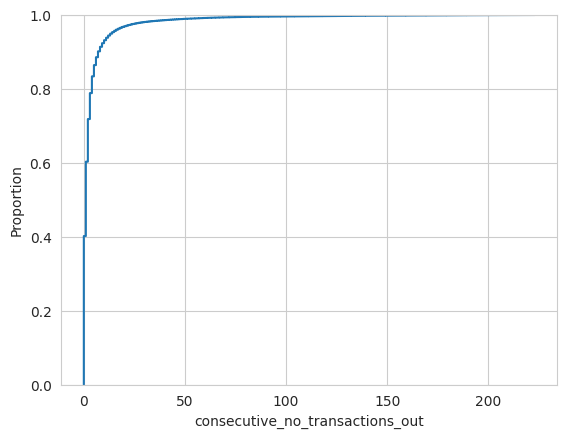

In [47]:
sns.ecdfplot(data=cluster_station[cluster_station["status"] == 1], x="consecutive_no_transactions_out")

In [48]:
PROFILE_STATION_RULE[profile_station_activity]

36

In [49]:
cluster_station.shape

(65215, 26)

In [50]:
cluster_station.head(2)

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,cluster
6616164,106,2018-12-01 00:10:00,18,20,1,0,0,0,1,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1.046731,0.003525,-0.066745,1.084290,-1.043315,-0.729108,0.322639,1
6616165,106,2018-12-01 00:20:00,15,23,1,3,0,3,2,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1.762295,-0.016660,-0.032448,1.085313,-1.024725,-0.794536,1.016727,1


In [51]:
cluster_station.consecutive_no_transactions_out.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.98])

count    65215.000000
mean         3.655493
std         12.054918
min          0.000000
50%          1.000000
75%          3.000000
80%          4.000000
85%          5.000000
90%          7.000000
95%         14.000000
98%         29.000000
99%         52.000000
max        223.000000
Name: consecutive_no_transactions_out, dtype: float64

In [52]:
cluster_station.head()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,cluster
6616164,106,2018-12-01 00:10:00,18,20,1,0,0,0,1,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1.046731,0.003525,-0.066745,1.084290,-1.043315,-0.729108,0.322639,1
6616165,106,2018-12-01 00:20:00,15,23,1,3,0,3,2,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1.762295,-0.016660,-0.032448,1.085313,-1.024725,-0.794536,1.016727,1
6616166,106,2018-12-01 00:30:00,14,24,1,1,0,1,3,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,2.477858,-0.036844,0.001849,1.086337,-1.006134,-0.859964,1.710815,1
6616167,106,2018-12-01 00:40:00,14,24,1,2,2,4,0,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,0.331168,0.023709,-0.101042,1.083267,-1.061905,-0.663680,-0.371449,1
6616168,106,2018-12-01 00:50:00,13,25,1,1,0,1,1,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1.046731,0.003525,-0.066745,1.084290,-1.043315,-0.729108,0.322639,1


In [ ]:
# Graph
# Type date for better display in graph
cluster_station["date_str"] = cluster_station["date"].dt.strftime(date_format="%Y-%m-%d %H:%M")

fig = px.scatter(
    cluster_station,
    x="pca_1",
    y="pca_2",
    color="cluster",  #'cluster_info'
    hover_data=[
        "date_str",
        "available_bikes",
        "weekday",
        "hours",
        "consecutive_no_transactions_out",
        #'precipitation'
    ],
)
fig.show()

# Drop non usefull columns
cluster_station = cluster_station.drop("date_str", axis=1)

In [55]:
# fig = px.scatter_3d(cluster_station, x='pca_4', y='pca_5', z='pca_1', color="consecutive_no_transactions_out",
#                    hover_data=['date_str', 'available_stands', 'available_stands',
#                             'weekday', 'hours', 'consecutive_no_transactions_out',
#                             'precipitation'],
#                    opacity=0.5,
#                    size_max=1,
#                    labels={'cluster': 'Anomaly'},
#                )#color_discrete_sequence=px.colors.qualitative.Set1)
# fig.show()

In [56]:
cluster_station.cluster.value_counts(normalize=True)

cluster
 1    0.986261
-1    0.013739
Name: proportion, dtype: float64

In [57]:
cluster_station[cluster_station["cluster"] == -1]

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,cluster
6632621,106,2019-06-19 06:00:00,8,19,1,0,0,0,43,2,3,6,1.224647e-16,-1.000000e+00,0.433884,-0.900969,1.000000,6.123234e-17,30.903147,-0.944559,1.070896,-0.112419,1.590132,-1.342581,29.843137,-1
6632622,106,2019-06-19 06:10:00,8,19,1,0,0,0,44,2,3,6,1.224647e-16,-1.000000e+00,0.433884,-0.900969,1.000000,6.123234e-17,31.618710,-0.964743,1.105193,-0.111396,1.608722,-1.408009,30.537225,-1
6632623,106,2019-06-19 06:20:00,8,19,1,0,0,0,45,2,3,6,1.224647e-16,-1.000000e+00,0.433884,-0.900969,1.000000,6.123234e-17,32.334273,-0.984928,1.139490,-0.110373,1.627313,-1.473437,31.231313,-1
6632624,106,2019-06-19 06:30:00,8,19,1,0,0,0,46,2,3,6,1.224647e-16,-1.000000e+00,0.433884,-0.900969,1.000000,6.123234e-17,33.049837,-1.005112,1.173787,-0.109349,1.645903,-1.538864,31.925401,-1
6632625,106,2019-06-19 06:40:00,8,19,1,0,0,0,47,2,3,6,1.224647e-16,-1.000000e+00,0.433884,-0.900969,1.000000,6.123234e-17,33.765400,-1.025296,1.208085,-0.108326,1.664494,-1.604292,32.619489,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6681336,106,2020-08-28 04:50:00,9,31,1,0,0,0,46,3,5,4,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.866025,5.000000e-01,33.501326,-1.519645,0.253725,0.489125,0.633998,-2.854881,31.392609,-1
6681337,106,2020-08-28 05:00:00,9,31,1,0,0,0,47,3,5,5,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.965926,2.588190e-01,34.271773,-1.547599,0.288583,0.245021,0.636388,-2.875087,32.034920,-1
6681338,106,2020-08-28 05:10:00,9,31,1,0,0,0,48,3,5,5,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.965926,2.588190e-01,34.987336,-1.567783,0.322880,0.246044,0.654979,-2.940515,32.729008,-1
6681339,106,2020-08-28 05:20:00,9,31,1,0,0,0,49,3,5,5,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.965926,2.588190e-01,35.702900,-1.587967,0.357177,0.247067,0.673569,-3.005943,33.423096,-1


In [58]:
cluster_station[cluster_station["cluster"] == -1]["consecutive_no_transactions_out"].describe()

count    896.000000
mean      85.227679
std       46.891025
min       30.000000
25%       50.000000
50%       67.000000
75%      111.000000
max      223.000000
Name: consecutive_no_transactions_out, dtype: float64

In [59]:
cluster_station["anomaly"] = cluster_station["cluster"]

In [60]:
cluster_station[cluster_station["status"] == 0]["date"].nunique() / 6 / 24

1.9444444444444444

<Axes: xlabel='cluster', ylabel='consecutive_no_transactions_out'>

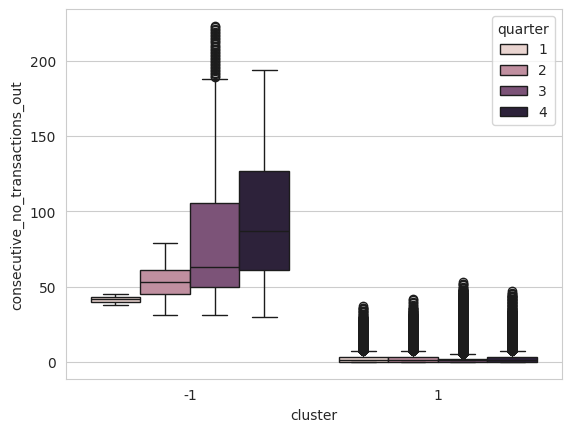

In [61]:
sns.boxplot(data=cluster_station, x="cluster", y="consecutive_no_transactions_out", hue="quarter")

In [62]:
cluster_station[cluster_station["cluster"] == -1].groupby("quarter")["cluster"].count()

quarter
1      8
2     98
3    471
4    319
Name: cluster, dtype: int64

In [67]:
# Lecture de profile des stations pour connaitre ceux que l'on clusterise
station_profile = read_station_profile(path_directory=ROOT_DATA_REF).to_pandas()

stations_id_to_fit = station_profile[station_profile["mean"] >= THRESHOLD_PROFILE_STATION]["station_id"].unique()

# Filter station we don't want to use
stations_id_to_fit = [station for station in stations_id_to_fit if station not in NON_USE_STATION_ID]

In [68]:
[station for station in stations_id_to_fit if station not in NON_USE_STATION_ID]

[np.uint16(124),
 np.uint16(15),
 np.uint16(60),
 np.uint16(18),
 np.uint16(10),
 np.uint16(68),
 np.uint16(130),
 np.uint16(2),
 np.uint16(105),
 np.uint16(120),
 np.uint16(11),
 np.uint16(110),
 np.uint16(9),
 np.uint16(23),
 np.uint16(3),
 np.uint16(16),
 np.uint16(20),
 np.uint16(136),
 np.uint16(42),
 np.uint16(21),
 np.uint16(131),
 np.uint16(59),
 np.uint16(45),
 np.uint16(172),
 np.uint16(6),
 np.uint16(36),
 np.uint16(24),
 np.uint16(108),
 np.uint16(19),
 np.uint16(125),
 np.uint16(135),
 np.uint16(37),
 np.uint16(139),
 np.uint16(99),
 np.uint16(28),
 np.uint16(57),
 np.uint16(7),
 np.uint16(98),
 np.uint16(8),
 np.uint16(41),
 np.uint16(40),
 np.uint16(58),
 np.uint16(55),
 np.uint16(109),
 np.uint16(1),
 np.uint16(4),
 np.uint16(100),
 np.uint16(134),
 np.uint16(174),
 np.uint16(101),
 np.uint16(56),
 np.uint16(104),
 np.uint16(43),
 np.uint16(54),
 np.uint16(44),
 np.uint16(102),
 np.uint16(133),
 np.uint16(103),
 np.uint16(5),
 np.uint16(127),
 np.uint16(65),
 np.uint16(

In [89]:
from vcub_keeper.reader.reader_utils import filter_periode

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
ts_activity.date.max()

Timestamp('2020-08-28 11:50:00')

In [91]:
station_id = 62

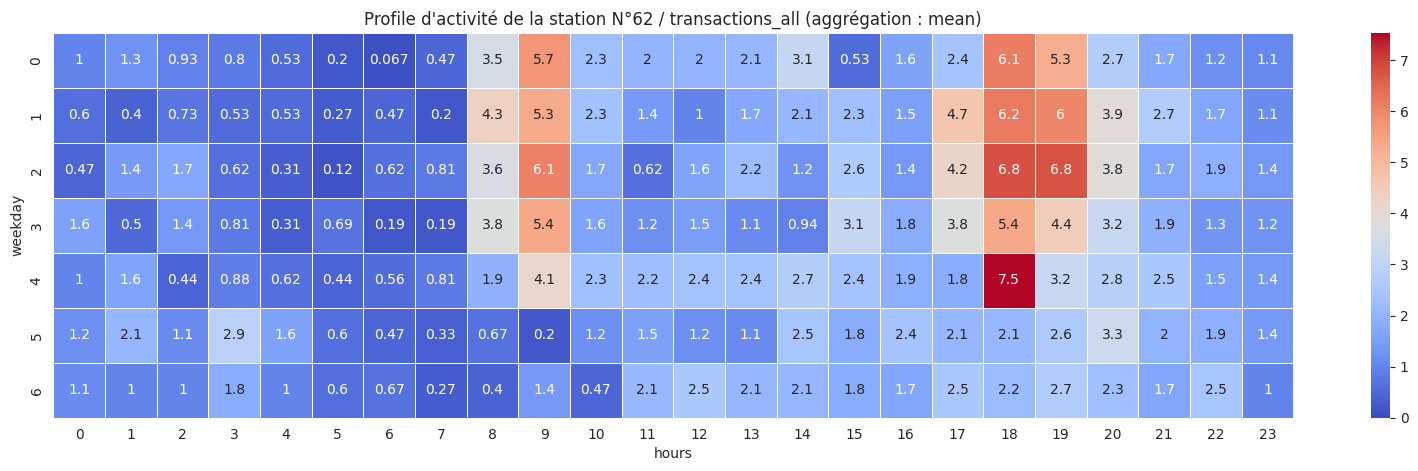

In [92]:
plot_profile_station(
    ts_activity[ts_activity["date"] >= "2020-03-17"],
    station_id=station_id,
    feature_to_plot="transactions_all",
    aggfunc="mean",
    filter_data=True,
    vmin=0,
)

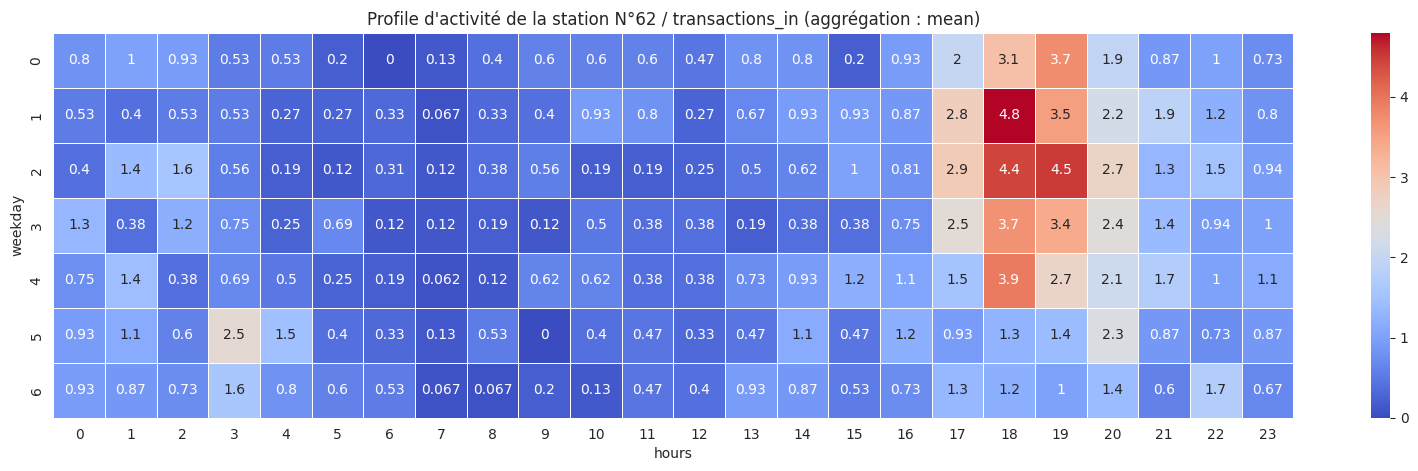

In [93]:
plot_profile_station(
    ts_activity[ts_activity["date"] >= "2020-03-17"],
    station_id=station_id,
    feature_to_plot="transactions_in",
    aggfunc="mean",
    filter_data=True,
    vmin=0,
)

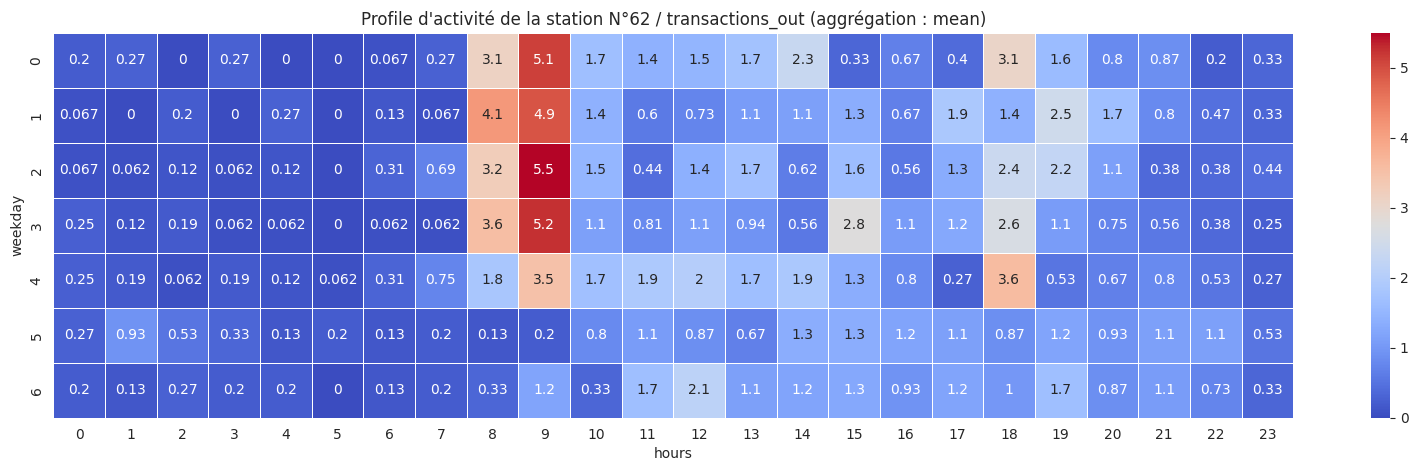

In [94]:
plot_profile_station(
    ts_activity[ts_activity["date"] >= "2020-03-17"],
    station_id=station_id,
    feature_to_plot="transactions_out",
    aggfunc="mean",
    filter_data=True,
    vmin=0,
)

#### On compare par rapport au données post-covid

In [95]:
from vcub_keeper.production.data import get_data_from_api_by_station, transform_json_station_data_to_df

station_json = get_data_from_api_by_station(station_id=station_id, start_date="2021/09/04", stop_date="2021/11/18")

station_df = transform_json_station_data_to_df(station_json)

station_df = get_consecutive_no_transactions_out(station_df)
station_df = station_df.to_pandas()

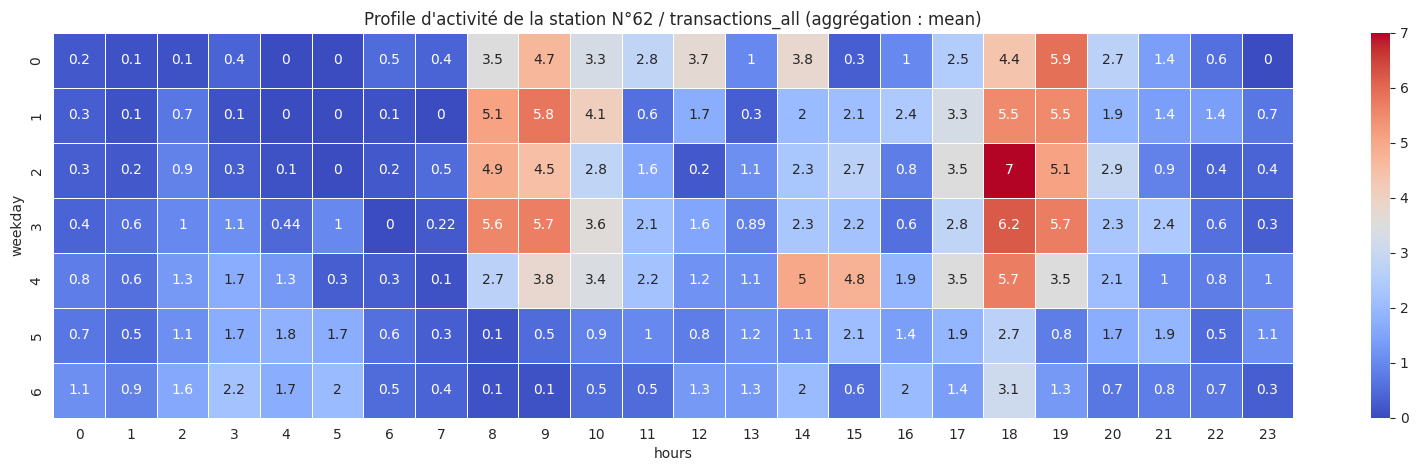

In [96]:
plot_profile_station(
    station_df, station_id=station_id, feature_to_plot="transactions_all", aggfunc="mean", filter_data=True, vmin=0
)

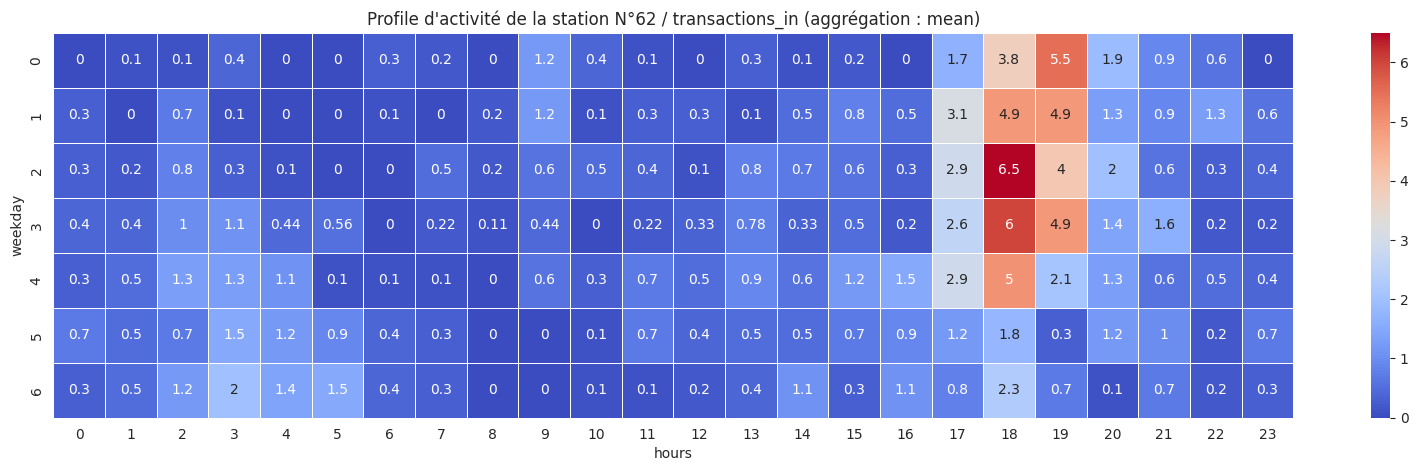

In [97]:
plot_profile_station(
    station_df, station_id=station_id, feature_to_plot="transactions_in", aggfunc="mean", filter_data=True, vmin=0
)

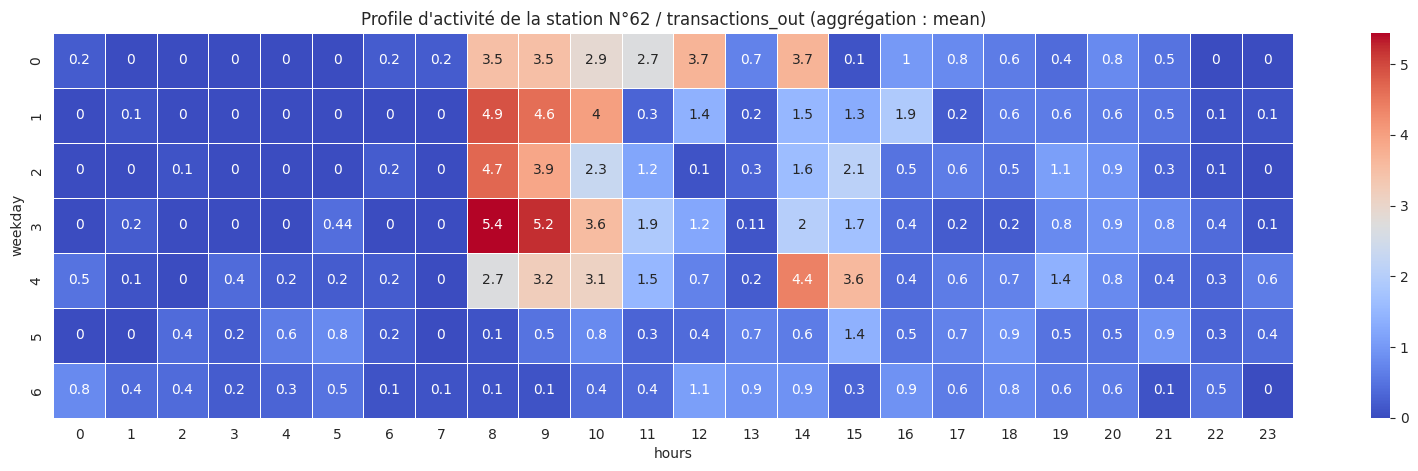

In [98]:
plot_profile_station(
    station_df, station_id=station_id, feature_to_plot="transactions_out", aggfunc="mean", filter_data=True, vmin=0
)

## Industrialisation

In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
# Lecture du fichier activité
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# Some features
# ts_activity = get_transactions_in(ts_activity)
# ts_activity = get_transactions_out(ts_activity)
# ts_activity = get_transactions_all(ts_activity)
ts_activity = get_consecutive_no_transactions_out(ts_activity)
ts_activity = ts_activity.collect().to_pandas()

In [118]:
station_id = 106

In [121]:
clf = train_cluster_station(ts_activity, station_id=station_id)
#  0.004647817613759431

Profile de la station N°106 : very high
Contamination de la station : 0.013795018979724127


In [122]:
# Faire une prédiction d'une station
station_pred = predict_anomalies_station(data=ts_activity, clf=clf, station_id=station_id)

In [123]:
station_pred["consecutive_no_transactions_out"].describe()

count    72853.000000
mean         5.114669
std         13.700496
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        223.000000
Name: consecutive_no_transactions_out, dtype: float64

In [124]:
station_pred.anomaly.value_counts()

anomaly
 1    70669
-1     2184
Name: count, dtype: int64

In [125]:
station_pred.anomaly.value_counts(normalize=True)

anomaly
 1    0.970022
-1    0.029978
Name: proportion, dtype: float64

In [126]:
station_pred["quarter"] = station_pred["date"].dt.quarter
station_pred[station_pred["anomaly"] == -1].groupby("quarter")["anomaly"].count()

quarter
1     343
2    1051
3     471
4     319
Name: anomaly, dtype: int64

In [130]:
# Score anomaly
station_pred["anomaly_score"] = (
    logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER])) * 100
)

In [131]:
station_pred[(station_pred["anomaly"] == -1) & (station_pred["consecutive_no_transactions_out"] < 36)].sort_values(
    "consecutive_no_transactions_out"
)

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly,anomaly_score
55297,106,2020-04-24 03:50:00,17,23,1,0,0,0,23,2,5,3,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.707107,7.071068e-01,-1,51.938971
57297,106,2020-05-08 03:30:00,11,29,1,0,0,0,23,2,5,3,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.707107,7.071068e-01,-1,51.938971
57298,106,2020-05-08 03:40:00,11,29,1,0,0,0,24,2,5,3,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.707107,7.071068e-01,-1,51.938971
55299,106,2020-04-24 04:10:00,17,23,1,0,0,0,25,2,5,4,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.866025,5.000000e-01,-1,51.415381
57568,106,2020-05-10 00:40:00,5,35,1,0,0,0,25,2,7,0,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,0.000000,1.000000e+00,-1,51.190406
57299,106,2020-05-08 03:50:00,11,29,1,0,0,0,25,2,5,3,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.707107,7.071068e-01,-1,54.658373
53081,106,2020-04-05 01:50:00,15,25,1,0,0,0,26,2,7,1,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,0.258819,9.659258e-01,-1,50.024928
54831,106,2020-04-17 05:30:00,14,26,1,0,0,0,26,2,5,5,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.965926,2.588190e-01,-1,51.708458
55300,106,2020-04-24 04:20:00,17,23,1,0,0,0,26,2,5,4,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.866025,5.000000e-01,-1,51.415381
56578,106,2020-05-03 01:50:00,9,31,1,0,0,0,26,2,7,1,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,0.258819,9.659258e-01,-1,50.024928


In [132]:
station_pred["decision_function"] = np.abs(clf.score_samples(station_pred[FEATURES_TO_USE_CLUSTER]))


station_pred["score_samples"] = -clf.score_samples(station_pred[FEATURES_TO_USE_CLUSTER])

In [133]:
station_pred.head()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly,anomaly_score,decision_function,score_samples
0,106,2018-12-01 00:10:00,18,20,1,0,0,0,1,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1,17.166711,0.482067,0.482067
1,106,2018-12-01 00:20:00,15,23,1,3,0,3,2,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1,16.826342,0.480860,0.480860
2,106,2018-12-01 00:30:00,14,24,1,1,0,1,3,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1,16.011860,0.477892,0.477892
3,106,2018-12-01 00:40:00,14,24,1,2,2,4,0,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1,17.457077,0.483081,0.483081
4,106,2018-12-01 00:50:00,13,25,1,1,0,1,1,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0,1,17.166711,0.482067,0.482067


In [134]:
station_pred[station_pred["anomaly"] == -1]["anomaly_score"].describe()

count    2184.000000
mean       68.779717
std        12.475485
min        50.024928
25%        58.863223
50%        66.651688
75%        77.616480
max        95.613287
Name: anomaly_score, dtype: float64

In [135]:
# On essaye de produire des probabilité à partir du score d'anomaly d'Iosaltion Forest
# OLD
# CF https://stackoverflow.com/a/69577241

from scipy.special import erf


def convert_probabilities(data, model):
    decision_scores = -model.decision_function(data)
    probs = np.zeros([data.shape[0], 2])  # int(model.classes)])
    pre_erf_score = (decision_scores - np.mean(decision_scores)) / (np.std(decision_scores) * np.sqrt(2))
    erf_score = erf(pre_erf_score)
    probs[:, 1] = erf_score.clip(0, 1).ravel()
    probs[:, 0] = 1 - probs[:, 1]
    return probs[:, 1]


# station_pred['anoamlie_score_scale_2'] = convert_probabilities(station_pred[FEATURES_TO_USE_CLUSTER],
#                                                               clf) * 100

In [136]:
station_pred[station_pred["anomaly"] == -1].groupby("quarter")["anomaly_score"].describe()

,count,mean,std,min,25%,50%,75%,max
quarter,,,,,,,,
1,343.0,60.805852,7.351681,50.077362,55.033042,60.795320,65.639340,83.113330
2,1051.0,66.400780,9.135525,50.024928,59.421781,66.210753,72.625258,89.838099
3,471.0,72.033265,15.313173,50.046106,57.854164,70.314221,89.837824,94.763731
4,319.0,80.387480,12.248189,50.366084,71.797283,85.389650,88.496375,95.613287


In [137]:
station_pred[station_pred["anomaly"] == 1].groupby("quarter")["anomaly_score"].describe()

,count,mean,std,min,25%,50%,75%,max
quarter,,,,,,,,
1,19311.0,16.248544,6.070452,7.154034,11.910097,15.114312,19.053763,49.961652
2,18638.0,19.389489,6.007445,10.685694,15.791793,17.756210,21.373401,49.845308
3,19613.0,15.638976,4.805852,8.291303,12.889689,14.739942,16.882937,49.985897
4,13107.0,19.519546,5.102105,11.766172,15.662073,18.344531,22.432686,49.793456


In [138]:
max_value = station_pred["consecutive_no_transactions_out"].max()
station_pred["anomaly_display"] = 0
station_pred.loc[station_pred["anomaly"] == -1, "anomaly_display"] = 100  # max_value

# plot_station_activity(station_pred,
#                      features_to_plot=['consecutive_no_transactions_out',
#                                        'anomaly_display',
#                                        'anomaly_score'
#                                       ],
#                      station_id=station_id)

In [139]:
# Export model
# export_model(clf, station_id=station_id, path_directory=ROOT_MODEL)

In [140]:
# Chargement model
# clf = load_model(station_id=station_id)

In [141]:
# Analyser données graphique à partir d'une date
# station_pred[station_pred.date >= "2019-04-16 11:10:00"].head(80)
station_pred

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly,anomaly_score,decision_function,score_samples,anomaly_display
0,106,2018-12-01 00:10:00,18,20,1,0,0,0,1,4,6,0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,0.000000,1.000000,1,17.166711,0.482067,0.482067,0
1,106,2018-12-01 00:20:00,15,23,1,3,0,3,2,4,6,0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,0.000000,1.000000,1,16.826342,0.480860,0.480860,0
2,106,2018-12-01 00:30:00,14,24,1,1,0,1,3,4,6,0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,0.000000,1.000000,1,16.011860,0.477892,0.477892,0
3,106,2018-12-01 00:40:00,14,24,1,2,2,4,0,4,6,0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,0.000000,1.000000,1,17.457077,0.483081,0.483081,0
4,106,2018-12-01 00:50:00,13,25,1,1,0,1,1,4,6,0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,0.000000,1.000000,1,17.166711,0.482067,0.482067,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72848,106,2020-08-28 11:10:00,20,20,1,8,10,8,0,3,5,11,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.258819,-0.965926,1,17.734482,0.484037,0.484037,0
72849,106,2020-08-28 11:20:00,20,20,1,0,0,0,1,3,5,11,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.258819,-0.965926,1,17.898570,0.484598,0.484598,0
72850,106,2020-08-28 11:30:00,20,20,1,0,0,0,2,3,5,11,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.258819,-0.965926,1,17.984440,0.484889,0.484889,0
72851,106,2020-08-28 11:40:00,20,20,1,0,0,0,3,3,5,11,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.258819,-0.965926,1,18.578386,0.486877,0.486877,0


In [142]:
# Pour le language des dates sur le graphique
# NE MARCHE PAS
# import locale

# locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# ts_activity.head().date.dt.strftime('%a %Y-%m-%d %H:%M') # MARCHE SUR PANDAS

In [143]:
# start_date = "2019-01-01"
# end_date = "2019-01-06"

# plott = plot_station_anomalies_with_score(data=station_pred, clf=clf,
#                              station_id=station_id,
#                              #start_date=start_date,
#                              #end_date=start_date,
#                              return_data=True,
#                              offline_plot=False,
#                              return_plot=False
#                                         )

In [ ]:
fig = px.scatter(
    x=clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]),
    y=logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]), k=20),
)
fig.show()

<Axes: ylabel='Proportion'>

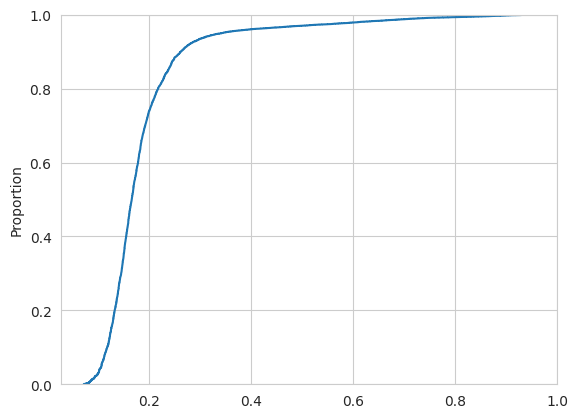

In [146]:
# fig = px.ecdf(decision_function)
sns.ecdfplot(logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]), k=20))

In [147]:
logistic_predict_proba_from_model(-0.182787, k=20)

np.float64(0.9748086373851281)

In [148]:
logistic_predict_proba_from_model(0.15, k=20)

np.float64(0.04742587317756678)

### Analyse du score d'anomalie pour un trimestre différent

In [149]:
test_saison = [
    {"station_id": station_id, "date": pd.Timestamp("2019-01-05 09:40:00"), "consecutive_no_transactions_out": 38},
    {"station_id": station_id, "date": pd.Timestamp("2019-04-06 09:40:00"), "consecutive_no_transactions_out": 38},
    {"station_id": station_id, "date": pd.Timestamp("2019-07-06 09:40:00"), "consecutive_no_transactions_out": 38},
    {"station_id": station_id, "date": pd.Timestamp("2019-10-05 09:40:00"), "consecutive_no_transactions_out": 38},
]

test_saison_df = pd.DataFrame(test_saison)
test_saison_df

,station_id,date,consecutive_no_transactions_out
0,106,2019-01-05 09:40:00,38
1,106,2019-04-06 09:40:00,38
2,106,2019-07-06 09:40:00,38
3,106,2019-10-05 09:40:00,38


In [150]:
test_saison_df_build = process_data_cluster(pl.from_pandas(test_saison_df)).to_pandas()
test_saison_df_build

,station_id,date,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours
0,106,2019-01-05 09:40:00,38,1,6,9,1.000000e+00,6.123234e-17,-0.781831,0.62349,0.707107,-0.707107
1,106,2019-04-06 09:40:00,38,2,6,9,1.224647e-16,-1.000000e+00,-0.781831,0.62349,0.707107,-0.707107
2,106,2019-07-06 09:40:00,38,3,6,9,-1.000000e+00,-1.836970e-16,-0.781831,0.62349,0.707107,-0.707107
3,106,2019-10-05 09:40:00,38,4,6,9,-2.449294e-16,1.000000e+00,-0.781831,0.62349,0.707107,-0.707107


In [151]:
test_saison_df_build["anomaly_score"] = (
    logistic_predict_proba_from_model(clf.decision_function(test_saison_df_build[FEATURES_TO_USE_CLUSTER])) * 100
)
test_saison_df_build

,station_id,date,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly_score
0,106,2019-01-05 09:40:00,38,1,6,9,1.000000e+00,6.123234e-17,-0.781831,0.62349,0.707107,-0.707107,50.600228
1,106,2019-04-06 09:40:00,38,2,6,9,1.224647e-16,-1.000000e+00,-0.781831,0.62349,0.707107,-0.707107,56.343653
2,106,2019-07-06 09:40:00,38,3,6,9,-1.000000e+00,-1.836970e-16,-0.781831,0.62349,0.707107,-0.707107,39.431555
3,106,2019-10-05 09:40:00,38,4,6,9,-2.449294e-16,1.000000e+00,-0.781831,0.62349,0.707107,-0.707107,41.378283


In [152]:
test_saison_df_build[["station_id", "date", "quarter", "weekday", "consecutive_no_transactions_out", "anomaly_score"]]

,station_id,date,quarter,weekday,consecutive_no_transactions_out,anomaly_score
0,106,2019-01-05 09:40:00,1,6,38,50.600228
1,106,2019-04-06 09:40:00,2,6,38,56.343653
2,106,2019-07-06 09:40:00,3,6,38,39.431555
3,106,2019-10-05 09:40:00,4,6,38,41.378283


In [154]:
filter_periode(pl.from_pandas(station_pred), non_use_station_id=NON_USE_STATION_ID).to_pandas().groupby(
    "quarter"
).size()

quarter
1    17517
2    14188
3    20084
4    13426
dtype: int64

### Réalistion des tests

Cf fichier tests.test_ml.py

In [158]:
from vcub_keeper.ml.cluster import logistic_predict_proba_from_model, predict_anomalies_station, train_cluster_station
from vcub_keeper.production.data import get_data_from_api_by_station, transform_json_station_data_to_df
from vcub_keeper.transform.features_factory import get_consecutive_no_transactions_out, process_data_cluster

# test_data name in test script
test_data = [
    (
        [{"station_id": 106, "date": pd.Timestamp("2018-12-01 00:10:00"), "consecutive_no_transactions_out": 0}],
        1,
    ),  # Should be OK
    (
        [{"station_id": 106, "date": pd.Timestamp("2020-08-25 03:50:00"), "consecutive_no_transactions_out": 46}],
        -1,
    ),  # Should be KO (anomaly)
]

station_id = 106
start_date = "2018-12-01"
stop_date = "2020-08-28"
profile_station_activity = "very high"  # https://github.com/armgilles/vcub_keeper/issues/56#issuecomment-1007612158

station_json = get_data_from_api_by_station(station_id=station_id, start_date=start_date, stop_date=stop_date)

station_df = transform_json_station_data_to_df(station_json)

# Create feature basé sur l'absence consécutive de prise de vcub sur la station
station_df = get_consecutive_no_transactions_out(station_df)

clf = train_cluster_station(
    station_df.to_pandas(), station_id=station_id, profile_station_activity=profile_station_activity
)

# Prediction
station_df_pred = predict_anomalies_station(data=station_df.to_pandas(), clf=clf, station_id=station_id)

# Check prediction sanity
# Check features creation is the same as FEATURES_TO_USE_CLUSTER (from config.py)
assert (station_df_pred[FEATURES_TO_USE_CLUSTER].columns == FEATURES_TO_USE_CLUSTER).any()  # noqa: S101

Using specifique profile station activity : very high
Profile de la station N°106 : very high
Contamination de la station : 0.012818927815296255


In [159]:
station_df_pred[
    station_df_pred["date"].isin(
        [
            "2018-12-01 00:10:00",  # Date in test_data
            "2020-08-25 03:50:00",
        ]
    )
]

/tmp/ipykernel_2324896/3197435770.py:1: FutureWarning:

The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



,date,station_id,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly
0,2018-12-01 00:10:00,106,18.0,20.0,1.0,0,0,0,1,4,6,0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,0.000000,1.000000,1
91174,2020-08-25 03:50:00,106,26.0,14.0,1.0,0,0,0,46,3,2,3,-1.000000e+00,-1.836970e-16,0.974928,-0.222521,0.707107,0.707107,-1


In [160]:
station_df_pred["anomaly_score"] = (
    logistic_predict_proba_from_model(clf.decision_function(station_df_pred[FEATURES_TO_USE_CLUSTER])) * 100
)

In [161]:
# test_data#['date']
for i in test_data:
    print(i)

([{'station_id': 106, 'date': Timestamp('2018-12-01 00:10:00'), 'consecutive_no_transactions_out': 0}], 1)
([{'station_id': 106, 'date': Timestamp('2020-08-25 03:50:00'), 'consecutive_no_transactions_out': 46}], -1)


In [162]:
i[0][0]["date"]

Timestamp('2020-08-25 03:50:00')